##helper functions

In [0]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
# remove grid lines
import numpy as np
import time
import cv2
import random
import math

In [0]:
# funcrion to read and resize an image
def read_and_resize_image(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
      img_result = cv2.bitwise_not(img_result)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      # convert to rgb
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    img_result = cv2.resize(img_result, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
    return img_result

 
# function for colors arrat generation
def generate_colors(num):
  r = lambda: random.randint(0,255)
  return [(r(),r(),r()) for _ in range(num)]

#Problem 1

## adaptive thresholding 

In [0]:
def gaussian_weight(x, y, sigma):
  return np.exp(-(x**2 + y**2) / (2*sigma**2)) / (2*math.pi * sigma**2)  


def adaptive_thresholding(image, method, threshold_type, block_size):
  """
  Function calculates adaptive thresholding for a given image
  Input :   image : grayscale or color image
  thresholding_type : type of thresholding ; possible values : ’mean ’ and ’gaussian ’
  block_size : kernel size in which the threshold value is calculated for the current pixel
  Output :   image_bw : binary thresholded image
  """
  if image.ndim==3:
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
  image_bw=np.zeros(image.shape)
  thresh_mat=np.zeros(image.shape)
  limit_mask = int((block_size-1)/2)
  limit_pixel = int((block_size-1)/2)
  step_pixel = block_size
#   sigma= 1       
  sigma = 0.3*((block_size-1)*0.5 - 1) + 0.8  
  
  
  if threshold_type=='mean':
    if method=='OpenCV':
      step_pixel = 1
      limit_pixel =0
      
      for i in range(limit_pixel , image.shape[0] - limit_pixel, step_pixel):
        for j in range(limit_pixel , image.shape[1] - limit_pixel, step_pixel):
          
          i_min=max(0,i - limit_mask)
          j_min=max(0,j - limit_mask)
          i_max=min(i + limit_mask + 1,image.shape[0])
          j_max=min(j + limit_mask + 1,image.shape[1])

          mask= np.zeros(image.shape)
          mask[i_min: i_max, j_min : j_max]=1

          threshold =np.mean(image[mask==1])   

          image_bw[i,j]=0 if image[i,j]>threshold else 255

          
    else:      
      for i in range(limit_pixel , image.shape[0] - limit_pixel, step_pixel):
        for j in range(limit_pixel , image.shape[1] - limit_pixel, step_pixel):

          mask= np.zeros(image.shape)
          mask[i - limit_mask:i + limit_mask + 1, j - limit_mask :j + limit_mask + 1]=1

          threshold =np.mean(image[mask==1])  
          thresh_mat[mask==1]=threshold
        
        
      for i in range(0 , image.shape[0]):
        for j in range(0 , image.shape[1]):
          i_min=max(0,i-1)
          j_min=max(0,j-1)
          i_max=min(i+2,image.shape[0])
          j_max=min(j+2,image.shape[1])

          mask= np.zeros(image.shape)
          mask[i_min : i_max, j_min : j_max]= 1
          threshold =np.mean(np.unique(thresh_mat[mask==1]))
          image_bw[i,j]=0 if image[i,j]>threshold else 255 

        
  if threshold_type=='gaussian':
    if method=='OpenCV':
      step_pixel=1
      limit_pixel =0
      
      for i in range(limit_pixel , image.shape[0] - limit_pixel, step_pixel):
        for j in range(limit_pixel , image.shape[1] - limit_pixel, step_pixel):

          total_weight=0.0
          mask=np.full((image.shape[0],image.shape[1]),0.0)
          
          for x in range(- limit_mask , limit_mask + 1):
            for y in range(- limit_mask , limit_mask + 1):
              if i+x >=0 and i+x < image.shape[0] and j+y >=0 and j+y < image.shape [1]:
                mask[i + x,j + y] += gaussian_weight(x,y,sigma)
                total_weight += mask[i + x, j + y] 
              
              elif i+x <0 and j+y < image.shape [1]:
                mask[i - x,j + y] += gaussian_weight(x,y,sigma)
              elif i+x <0 and j+y > image.shape [1]:
                mask[i - x,j - y] += gaussian_weight(x,y,sigma)
              elif j+y<0 and i+x < image.shape[0]: 
                mask[i + x,j - y] += gaussian_weight(x,y,sigma)
              elif j+y<0 and i+x > image.shape[0]: 
                mask[i - x,j - y] += gaussian_weight(x,y,sigma)
              elif j+y<0 and i+x<0:    
                  mask[i - x,j - y] += gaussian_weight(x,y,sigma)       
                
#           mask= mask / total_weight
          threshold = sum((image * mask).flatten()) 
          image_bw[i,j] = 0 if image[i,j] > threshold else 255 

    else:
      
      for i in range(limit_pixel , image.shape[0] - limit_pixel, step_pixel):
        for j in range(limit_pixel , image.shape[1] - limit_pixel, step_pixel):

          total_weight=0.0
          mask=np.full((image.shape[0],image.shape[1]),0.0)
          for x in range(- limit_mask , limit_mask + 1):
            for y in range(- limit_mask , limit_mask + 1):
              mask[i + x,j + y] = gaussian_weight(x,y,sigma)
              total_weight+= mask[i + x, j + y]
              
#           mask= mask / total_weight
          threshold = sum((image * mask).flatten()) 
          thresh_mat[mask!=0] = threshold

      for i in range(0 , image.shape[0]):
        for j in range(0 , image.shape[1]):
          i_min=max(0,i-1)
          j_min=max(0,j-1)
          i_max=min(i+2,image.shape[0])
          j_max=min(j+2,image.shape[1])

          mask= np.zeros(image.shape)
          mask[i_min : i_max, j_min : j_max]=1
          threshold = np.mean( np.unique( thresh_mat[mask==1] ) )
          image_bw[i,j] = 0 if image[i,j] > threshold else 255 

  return image_bw

##main code

In [0]:
img= read_and_resize_image('sudoku-original.jpg', grayscale = False)
# img=cv2.imread('Adaptive_thresholding.jpg')
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

In [0]:
#@title parameters and method { run: "auto" }

method = 'OpenCV_method' #@param ['OpenCV_method', 'subimages_method']
threshold_type = 'gaussian' #@param ['mean', 'gaussian']
block_size = 11 #@param {type:"slider", min:1, max: 225, step:2}

ad_thresh_gaussian=adaptive_thresholding(img_gray, method, threshold_type, block_size)

In [0]:
#@title parameters and method { run: "auto" }

method = 'OpenCV_method' #@param ['OpenCV_method', 'subimages_method']
threshold_type = 'mean' #@param ['mean', 'gaussian']
block_size = 11 #@param {type:"slider", min:1, max: 225, step:2}

ad_thresh_mean=adaptive_thresholding(img_gray, method, threshold_type, block_size)

In [0]:
#@title parameters and method { run: "auto" }

threshold_types  = {'mean':cv2.ADAPTIVE_THRESH_MEAN_C,'gaussian':cv2.ADAPTIVE_THRESH_GAUSSIAN_C}
threshold_type = 'gaussian' #@param ['mean', 'gaussian']
block_size = 11 #@param {type:"slider", min:1, max: 225, step:2}

ad_thresh_OC_gaussian = cv2.adaptiveThreshold(img_gray,255,threshold_types[threshold_type],cv2.THRESH_BINARY_INV,block_size,0)

In [0]:
#@title parameters and method { run: "auto" }

threshold_types  = {'mean':cv2.ADAPTIVE_THRESH_MEAN_C,'gaussian':cv2.ADAPTIVE_THRESH_GAUSSIAN_C}
threshold_type = 'mean' #@param ['mean', 'gaussian']
block_size = 11 #@param {type:"slider", min:1, max: 225, step:2}

ad_thresh_OC_mean = cv2.adaptiveThreshold(img_gray,255,threshold_types[threshold_type],cv2.THRESH_BINARY_INV,block_size,0)

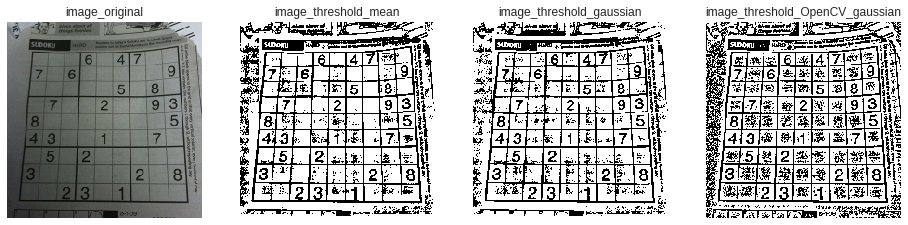

In [0]:
plt.subplot(141)
plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.title('image_original')

plt.subplot(142)
plt.imshow(ad_thresh_mean)
plt.xticks([]),plt.yticks([])
plt.title('image_threshold_mean')

plt.subplot(143)
plt.imshow(ad_thresh_gaussian)
plt.xticks([]),plt.yticks([])
plt.title('image_threshold_gaussian')

plt.subplot(144)
plt.imshow(ad_thresh_OC_gaussian)
plt.xticks([]),plt.yticks([])
plt.title('image_threshold_OpenCV_gaussian')

plt.show()

# Problem2

## calculate_size_and_rank

In [0]:
def pixelToSize (pixel_value, dim, units):
  if units == 'mm':
    return pixel_value * ((210 / dim[0]+ 297/dim[1])/2) 
  elif units == 'cm':
    return pixel_value * ((21 / dim[0]+ 29.7/dim[1])/2)
  elif units == 'm':
    return pixel_value * ((0.21 / dim[0]+ 0.297/dim[1])/2)

In [0]:
def pixelToSize_area(pixel_value, dim, units):
  if units == 'mm':
    return pixel_value * 210 / dim[0] *297 / dim[1]
  elif units == 'cm':
    return pixel_value * 21 / dim[0] * 29.7 / dim[1]
  elif units == 'm':
    return pixel_value * 0.21 / dim[0] * 0.297 / dim[1] 

In [0]:
def thresholding(img_obj_gray, thresh_val, block_size, morph, bitwise, use_otsu, use_morph_ope):
  if use_otsu:
    ret,img_bw = cv2.threshold(img_obj_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  else:
    ret,img_bw = cv2.threshold(img_obj_gray,thresh_val,255,cv2.THRESH_BINARY)
  
  if use_morph_ope: 
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(block_size,block_size))
    img_bw = cv2.morphologyEx(img_bw, morphs[morph], kernel)

  if bitwise:
    img_bw = np.bitwise_not(img_bw)

  plt.imshow(img_bw)
  plt.xticks([]),plt.yticks([])
  plt.show()
    
  return img_bw

In [0]:
def extract_paper(img, img_bw, epsilon_factor): 
  
  ########################################   extracting the contours    ######################################""   

  img1, contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  img_contours=img.copy()
  cv2.drawContours(img_contours, contours, -1, (255,0,0), 10)

  plt.subplot(121),plt.imshow(img1)
  plt.title('BINARY Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(img_contours)
  plt.title('image_contours'), plt.xticks([]), plt.yticks([])
  plt.show()
  
   ########################################   extracting the contours of the paper   ######################################""   

  contours_list=[];

  for i in range(len(contours)):
    cnt = contours[i]
    for scale in range (1, 10):
      epsilon = epsilon_factor*0.01*scale*cv2.arcLength(cnt,True)
      approx = cv2.approxPolyDP(cnt,epsilon,True)
      if (len(approx)==4 and cv2.contourArea(approx)< 0.75*img.shape[0]*img.shape[1] and cv2.contourArea(approx)>0.25* img.shape[0]*img.shape[1]):
        contours_list.append(approx)
        break
  if len(contours_list)==0:
    import sys
    sys.exit("error!! No contour with four points found, please adjust the parameter epsilon_factor or redo the thresholding ")
    
  img_contours=img.copy()
  cv2.drawContours(img_contours, contours_list[0], -1, (255,0,0), 20)
  plt.imshow(img_contours)
  plt.title('contour paper with four points')
  plt.xticks([]),plt.yticks([])
  plt.show
  
  ########################################   extracting the paper from the image   ######################################""   

  contour= contours_list[0]
  contour = contour[:,0,:]
  x = np.sort(contour[:,0])
  y = np.sort(contour[:,1])
  
  if contour[np.where(contour==x[0])[0]][0,1] < contour[np.where(contour==x[1])[0]][0,1]:
    ind0 = 0
    ind2 = 1
  else:
    ind0 = 1
    ind2 = 0
  if contour[np.where(contour==x[2])[0]][0,1] < contour[np.where(contour==x[3])[0]][0,1]:
    ind1 = 2
    ind3 = 3
  else:
    ind1 = 3
    ind3 = 2
    
  pts1 = np.float32([[ x[ind0] , contour[np.where(contour==x[ind0])[0]][0,1] ], [ x[ind1] , contour[np.where(contour==x[ind1])[0]][0,1] ], [ x[ind2] , contour[np.where(contour==x[ind2])[0]][0,1] ], [ x[ind3] , contour[np.where(contour==x[ind3])[0]][0,1] ] ])
  pts2 = np.float32([[0,0],[2300,0],[0,1100],[2300,1100]])

  M = cv2.getPerspectiveTransform(pts1,pts2)
  img_obj = cv2.warpPerspective(img,M,(2300,1100))

  plt.subplot(121),plt.imshow(img_contours),plt.title('Input')
  plt.subplot(122),plt.imshow(img_obj),plt.title('Output')
  plt.show()  

  return img_obj

In [0]:
def extract_objects(img_bw, img_obj):
  
  
  ########################################   extracting the contours and filtering contours   ######################################""   
  
  img1, contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  img_contours=img_obj.copy()
  cv2.drawContours(img_contours, contours, -1, (255,0,0), 7)
  hierarchy = hierarchy[0,:,:]

  contours_obj=[]
  for contour, hierarch in zip(contours, hierarchy):
    if cv2.contourArea(contour)< 0.8*img_contours.shape[0]*img_contours.shape[1] and cv2.contourArea(contour)> 0.01*img_contours.shape[0]*img_contours.shape[1] and hierarch[3]==-1:
      contours_obj.append(contour)
  img_contours=img_obj.copy()
  
  if len(contours_obj)==0:
    import sys
    sys.exit("error!! No objects contours detected")
    
  cv2.drawContours(img_contours, contours_obj, -1, (255,0,0), 7)
  plt.subplot(121),plt.imshow(img_contours),plt.xticks([]),plt.yticks([]), plt.title('contours objects')
  plt.subplot(122),plt.imshow(img1),plt.xticks([]),plt.yticks([]) , plt.title('binary image')
  plt.show()
  
  ############################################### obtaining the sorted dimensions of the objects ###############################################
  
  titles= []
  images= []
  final_image=img_obj.copy()

  dimensions= np.zeros([len(contours_obj), 8])*1.0
 
  for i, contour in enumerate(contours_obj):
    img_contours=img_obj.copy()
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_contours,[box],0,(255,0,0),10)
    cv2.drawContours(final_image,[contour],0,(0,255,0),5)
    
    height= rect[1][1]
    width= rect[1][0]
    
    if height<width:
      temp= width
      width= height
      height= temp
      
    print( 'height= {} width ={}'.format(height, width) )
    perimeter= cv2.arcLength(contour,True)
    area= cv2.contourArea(contour)
    x_center=  rect[0][0]
    
    dimensions[i, 0]= area
    dimensions[i, 1]= height
    dimensions[i, 2]= width
    dimensions[i, 3]= perimeter
    dimensions[i, 4]= x_center  
  
    print('center (x,y), (width, height) and angle of rotation of the object {}: {}'.format(i+1, rect) )
    titles.append('image {}'.format(i+1))
    images.append(img_contours) 
  
  for i in range(len(contours_obj)):
    plt.subplot(1,len(contours_obj),i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([]) 
  plt.show()


  ###########################################  applying connected components ##########################################
  connectivity=4
  n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_bw, connectivity, cv2.CV_32S)
  colors = generate_colors(n_labels)
  labeled_image = np.zeros((img_bw.shape[0],img_bw.shape[1],3), dtype=np.uint8)

  k=1
  print('Connected components parameters:')
  print('================================================')

  # loop over all components and determine if it is a number
  for (i, label) in enumerate(range(0, n_labels)):
    if (stats[i, cv2.CC_STAT_AREA] < 0.8*img_bw.shape[0]*img_bw.shape[1] and stats[i, cv2.CC_STAT_AREA]> 0.01*img_bw.shape[0]*img_bw.shape[1]):
      labeled_image[labels == label,:]= colors[i]
      
      # centroid coordinates
      cent_x, cent_y = int(centroids[i,0]), int(centroids[i,1])
      dimensions[k-1, 5]= cent_x
      dimensions[k-1, 6]= stats[i, cv2.CC_STAT_AREA]
      dimensions[k-1, 7]= i
      
      cv2.circle(labeled_image,(cent_x, cent_y), 3, (255,0,0), -1)
      cv2.putText(labeled_image,'object '+str(k), (cent_x, cent_y), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(255,255,255),2)
      k+=1
      
      print('labeled component {}'.format(i))
      print('most left coordinate {}'.format(stats[i, cv2.CC_STAT_LEFT]))
      print('most top {}'.format(stats[i, cv2.CC_STAT_TOP ]))
      print('cc width {}'.format(stats[i, cv2.CC_STAT_WIDTH]))
      print('cc height {}'.format(stats[i, cv2.CC_STAT_HEIGHT ]))
      print('cc area {}'.format(stats[i, cv2.CC_STAT_AREA]))
      print('================================================')

  plt.title('colored labels')
  plt.xticks([]),plt.yticks([])
  plt.imshow(labeled_image)
  plt.show()
  
  ############################################"" obtaining the sorted dimensions of the objects (suite)################################""#

  dimensions[:, 5:8]= dimensions[np.argsort(dimensions[:, 5]), 5:8]
  dimensions[:, :5] = dimensions[np.argsort(dimensions[:, 4]), :5]
  
  if rank_by == 'area':
    inds= np.argsort(dimensions[:, 6])
  elif rank_by == 'width':
    inds= np.argsort(dimensions[:, 1])
  elif rank_by == 'height':
    inds= np.argsort(dimensions[:, 2])
  elif rank_by == 'perimeter':
    inds= np.argsort(dimensions[:, 3])

  sorted_heights = dimensions[inds, 1]
  sorted_widths = dimensions[inds, 2]
  sorted_perimeters = dimensions[inds, 3]
  sorted_areas_perim = dimensions[inds, 0]
  sorted_areas= dimensions[inds, 6]
  sorted_indices= dimensions[inds, 7]
  sorted_x = dimensions[inds, 5]
  
  m=-1
  l=-1
  for i in range(dimensions.shape[0]):
    for j in range (dimensions.shape[0]):
      if i!=j:
        if sorted_areas[i] > 0.99* sorted_areas[j] and sorted_areas[i] < sorted_areas[j]:
          if sorted_x[i] < sorted_x[j]:
            l=i
            m=j
          else:
            l=j
            m=i
  
  dim= img_obj.shape
  if units != 'pixels':
    sorted_heights = pixelToSize( sorted_heights, dim, units )
    sorted_widths = pixelToSize( sorted_widths, dim, units )
    sorted_perimeters = pixelToSize( sorted_perimeters, dim, units )
    sorted_areas = pixelToSize_area( sorted_areas, img_obj.shape, units )  
    
  #############################################  getting the final dimensions ##################################################"
  heights_=[]
  widths_=[]
  perimeters_=[]
  areas_=[]
  for i in range(len(sorted_heights)):
    heights_.append(sorted_heights[i])
    widths_.append(sorted_widths[i])
    perimeters_.append(sorted_perimeters[i])
    areas_.append(sorted_areas[i])
      
  ################################################  Plotting the final image #####################################"###########"
  p=-2
  for i in range (len(sorted_heights)):
    k= int(sorted_indices[i])
    cent_x, cent_y = int(centroids[k,0]), int(centroids[k,1])
    o=i+1
    
    if i==m  and p==-2:
      o= l+1
      p=-1
    if i==l and p==-1:
      o=m+1
    if i==l and p==-2:
      p=0
        
    cv2.putText(final_image,'object '+str(o), (cent_x, cent_y+ int(stats[k, cv2.CC_STAT_HEIGHT ]/4)), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(0,0,255),5)
    cv2.putText(final_image,'area' +str(round(sorted_areas[i], 2)) +str(units), (cent_x+30, cent_y+ int(stats[k, cv2.CC_STAT_HEIGHT ]/4) +40), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,0,0),5)
    cv2.putText(final_image,'height '+str(round(sorted_heights[i], 2)) +str(units), (cent_x+60, cent_y+ int(stats[k, cv2.CC_STAT_HEIGHT ]/4) + 80), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,0),5)
    cv2.putText(final_image,'width' +str(round(sorted_widths[i], 2)) +str(units), (cent_x+90, cent_y+ int(stats[k, cv2.CC_STAT_HEIGHT ]/4) + 120), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,0),5)
    cv2.putText(final_image,'perimeter' +str(round(sorted_perimeters[i], 2)) +str(units), (cent_x+120, cent_y+ int(stats[k, cv2.CC_STAT_HEIGHT ]/4) + 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,0),5)

  plt.title('final image with sizes')
  plt.xticks([]),plt.yticks([])
  plt.imshow(final_image)
  plt.show()
  
  sizes=(heights_, widths_, perimeters_, areas_)
  return final_image, sizes

In [0]:
def calculate_size_and_rank (img, parameters, units = 'm', rank_by='area'):
  
  """
  Function calculates objects sizes and rank them on image
  Input :   image : grayscale or color image
  units : unit of measurement of object size;   possible values : ’mm ’,’cm ’, ’m’ or ’pixels ’
  rank_by : object ranking parameter ;   possible values : ’height ’, ’width ’, ’perimeter ’ or ’area ’
  Output :   image_result : result image with ranking and measured objects sizes
  sizes : tuple of sizes (heights , widths , perimeters , areas ),  where heights , widths , perimeters , areas are lists
  """

  img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  img_gray = cv2.GaussianBlur(img_gray,(11,11),0)
  img_gray = cv2.medianBlur(img_gray,11)


  img_bw= thresholding(img_gray, parameters[0], parameters[1], parameters[2], 1, parameters[6], parameters[7])
  cond = input("if the result of the thresholding is satisfiable (the paper is detected as foreground) click 1, 0 otherwise ")
  if cond=='0':
    import sys
    sys.exit("Please adjust the parameters of the first thresholding (thresh_val1, block_size1 and morph1) and rerun the code")

  img_obj= extract_paper(img, img_bw, parameters[8])
  img_obj_gray = cv2.cvtColor(img_obj,cv2.COLOR_RGB2GRAY)

  img_bw= thresholding(img_obj_gray, parameters[3], parameters[4], parameters[5], 1, parameters[6], parameters[7])
  cond = input("if the result of the thresholding is satisfiable (the objects are detected as foreground) click 1, 0 otherwise ")
  if cond=='0':
    import sys
    sys.exit("Please adjust the parameters of the second threshoding (thresh_val1, block_size1 and morph1) and rerun the code")

  final_image= np.zeros(img.shape)
  sizes=()
  final_image, sizes= extract_objects(img_bw, img_obj)
  return final_image, sizes


## main code

IMG_20190214_112604.jpg


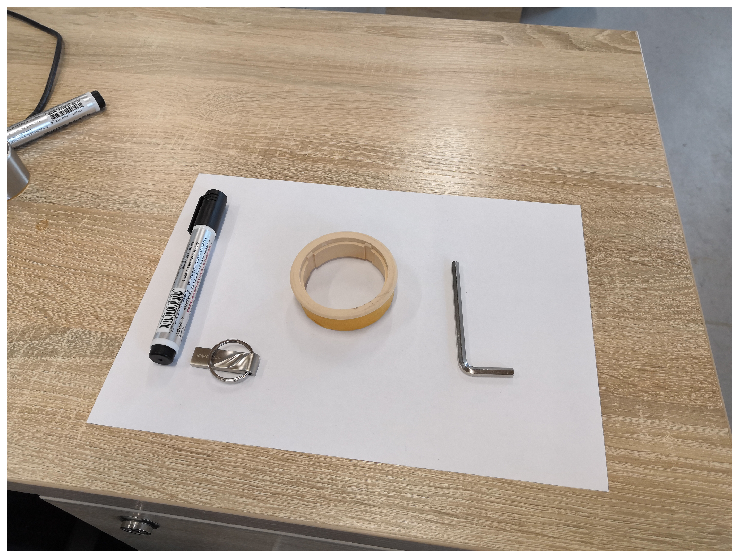

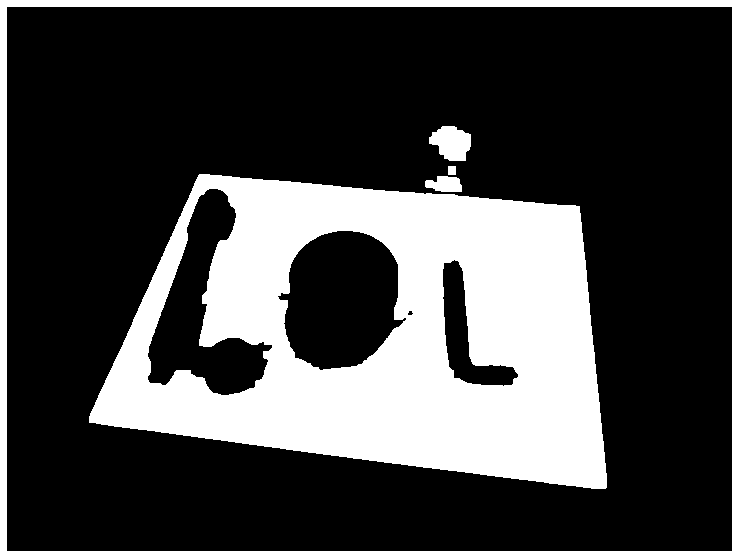

if the result of the thresholding is satisfiable (the paper is detected as foreground) click 1, 0 otherwise 1


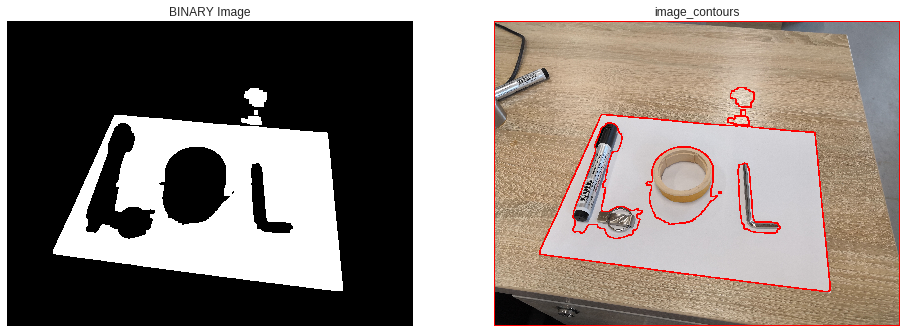

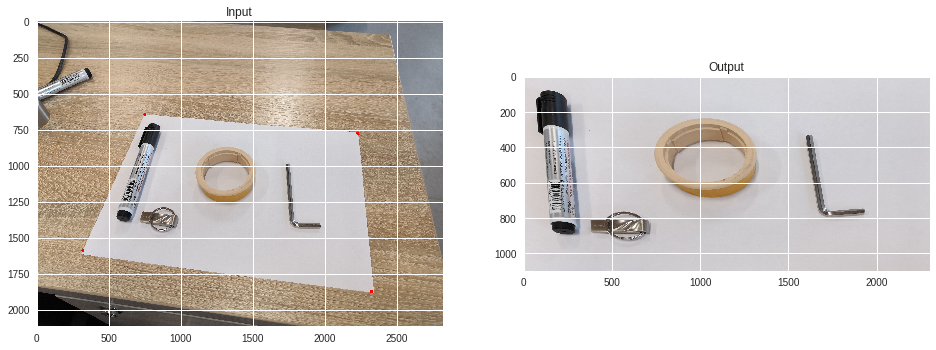

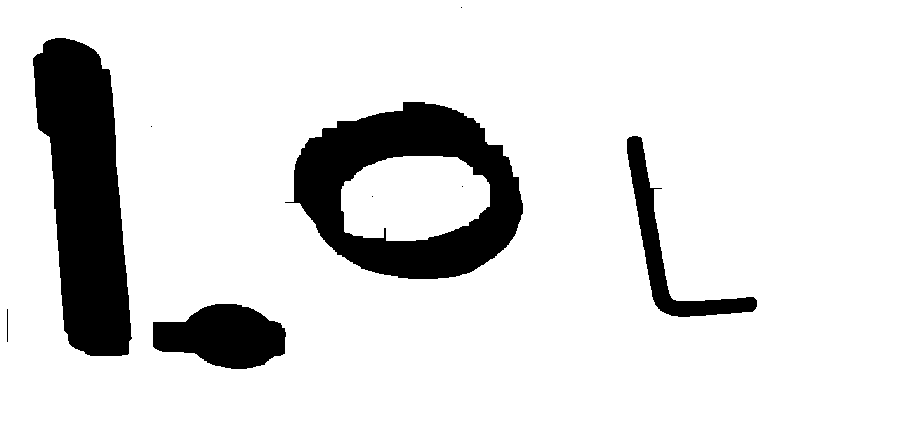

if the result of the thresholding is satisfiable (the objects are detected as foreground) click 1, 0 otherwise 1


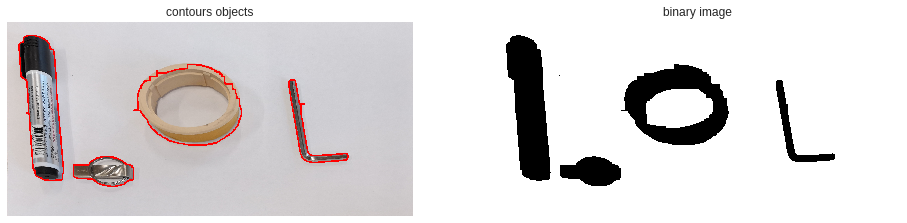

height= 341.8959045410156 width =167.60202026367188
center (x,y), (width, height) and angle of rotation of the object 1: ((546.0131225585938, 847.0282592773438), (167.60202026367188, 341.8959045410156), -88.40885925292969)
height= 550.9990844726562 width =219.08375549316406
center (x,y), (width, height) and angle of rotation of the object 2: ((1692.586669921875, 609.4864501953125), (219.08375549316406, 550.9990844726562), -35.40686798095703)
height= 597.3681030273438 width =460.6366882324219
center (x,y), (width, height) and angle of rotation of the object 3: ((1034.562255859375, 468.7610168457031), (460.6366882324219, 597.3681030273438), -75.40342712402344)
height= 827.1646118164062 width =199.093017578125
center (x,y), (width, height) and angle of rotation of the object 4: ((192.871337890625, 490.36407470703125), (199.093017578125, 827.1646118164062), -4.4971513748168945)


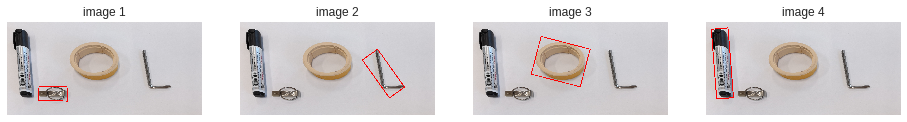

Connected components parameters:
labeled component 2
most left coordinate 67
most top 80
cc width 254
cc height 820
cc area 139387
labeled component 3
most left coordinate 717
most top 243
cc width 613
cc height 458
cc area 135987
labeled component 5
most left coordinate 1596
most top 332
cc width 335
cc height 466
cc area 28188
labeled component 11
most left coordinate 375
most top 764
cc width 343
cc height 169
cc area 40495


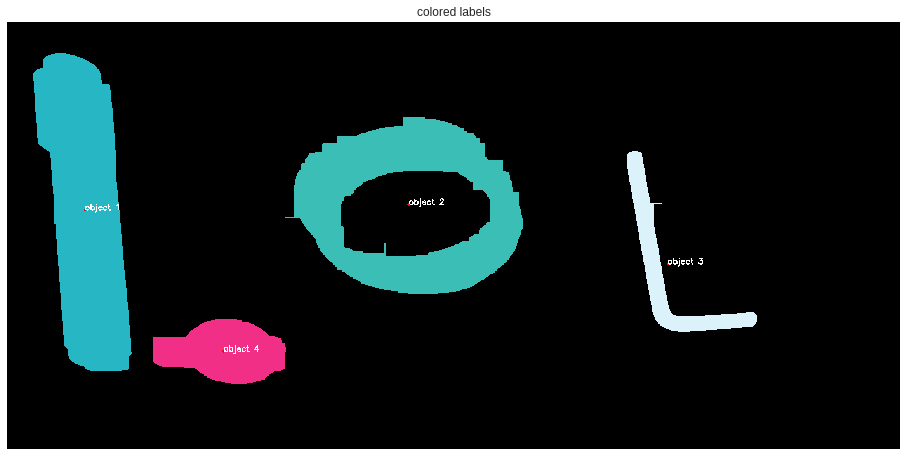

l=-1, m=-1, o=1
l=-1, m=-1, o=2
l=-1, m=-1, o=3
l=-1, m=-1, o=4


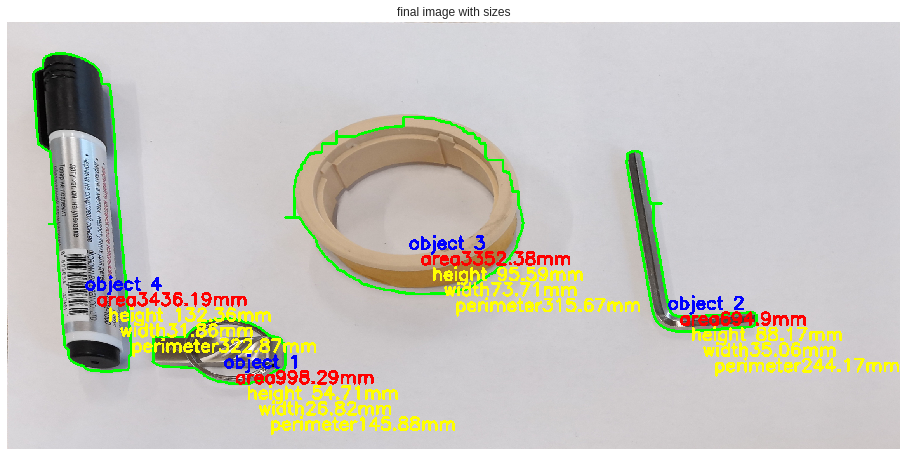

(heights, widths, perimeters, areas)= ([54.710101562620615, 88.17074282559481, 95.5907021781107, 132.36268501734074], [26.819635535078085, 35.057730597394254, 73.71097360904979, 31.858817457116167], [145.87873697059192, 244.16693925465046, 315.66946064038234, 322.8711583454123], [998.2897826086956, 694.8954782608695, 3352.3751739130435, 3436.192565217391])


In [0]:
####################################"" main code ###########################################

#@title Threshold, block_size and type of morphological operation { run: "auto" }
units = 'mm' #@param ['m', 'cm', 'mm', 'pixels']
rank_by = 'perimeter' #@param ['height', 'width', 'perimeter', 'area']
images = {'image1':'IMG_20190214_112225.jpg', 'image2':'IMG_20190214_112243.jpg', 'image3':'IMG_20190214_112245.jpg', 'image4':'IMG_20190214_112256.jpg', 'image5':'IMG_20190214_112324.jpg', 'image6':'IMG_20190214_112337.jpg', 'image7':'IMG_20190214_112344.jpg', 'image8':'IMG_20190214_112351.jpg', 'image9':'IMG_20190214_112446.jpg', 'image10':'IMG_20190214_112450.jpg', 'image11':'IMG_20190214_112454.jpg', 'image12':'IMG_20190214_112559.jpg', 'image13':'IMG_20190214_112604.jpg', 'image14':'IMG_20190214_112608.jpg', 'image15':'IMG_20190214_112620.jpg', 'image16':'IMG_20190214_112631.jpg', 'image17':'IMG_20190214_112637.jpg', 'image18':'IMG_20190214_112223.jpg'}
image = 'image13' #@param ['image1', 'image2', 'image3', 'image4', 'image5', 'image6', 'image7', 'image8', 'image9', 'image10', 'image11', 'image12', 'image13', 'image14', 'image15', 'image16', 'image17', 'image18']
morphs = {'OPEN':cv2.MORPH_OPEN, 'CLOSE':cv2.MORPH_CLOSE}
use_default_parameters = True #@param {type:"boolean"}
use_otsu = False #@param {type:"boolean"}
use_morph_ope = True #@param {type:"boolean"}
epsilon_factor = 1 #@param {type:"slider", min:0, max:10, step:1}

if not (use_default_parameters): 
  thresh_val1 = 188 #@param {type:"slider", min:0, max:255, step:1}
  block_size1 = 39 #@param {type:"slider", min:1, max:100, step:2}
  morph1 = 'OPEN' #@param ['OPEN', 'CLOSE']

  thresh_val2 = 175 #@param {type:"slider", min:0, max:255, step:1}
  block_size2 = 49 #@param {type:"slider", min:1, max:100, step:2}
  morph2 = 'OPEN' #@param ['OPEN', 'CLOSE']

elif image=='image18':
  thresh_val1= 187 
  block_size1= 37
  morph1= 'CLOSE' 
  thresh_val2= 160
  block_size2= 46   
  morph2= 'OPEN'
  
elif image=='image13':
  thresh_val1= 197 
  block_size1= 25
  morph1= 'OPEN' 
  thresh_val2= 175
  block_size2= 49   
  morph2= 'OPEN'

elif image=='image11':
  thresh_val1= 193 
  block_size1= 47
  morph1= 'OPEN' 
  thresh_val2= 175
  block_size2= 49   
  morph2= 'OPEN'

elif image=='image1':
  thresh_val1= 188 
  block_size1= 39
  morph1= 'OPEN' 
  thresh_val2= 175
  block_size2= 49   
  morph2= 'OPEN'
  
else:
  import sys
  sys.exit("no default parameters set for this image, please adjust them manually after unchecking the box use_default_parameters")

print(images[image])
img= read_and_resize_image(images[image], grayscale = False)

plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.show()

parameters= [thresh_val1, block_size1, morph1, thresh_val2, block_size2, morph2, use_otsu, use_morph_ope,  epsilon_factor]

final_image= np.zeros(img.shape)
sizes=()
final_image, sizes=  calculate_size_and_rank (img, parameters, units = 'm', rank_by='area')
print('(heights, widths, perimeters, areas)= {}'.format(sizes))
